In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, trange

from dataset import Dataset, get_transac_n_seconds
from models import Classifier, Projector, VAE
from trainers.drocc_trainer import DROCCTrainer, adjust_learning_rate
from trainers.dsvdd_trainer import DeepSVDD
from trainers.vae_trainer import LossVAE

In [8]:
# df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df = pd.read_csv('creditcard.csv')
df.head()

DEVICE="mps"
BATCH_SIZE=256

In [9]:
normal_rate = len(df[df['Class']==0])/ len(df)
anormal_rate = len(df[df['Class']==1])/ len(df)

print(f"normal rate: {normal_rate} ; anormal rate: {anormal_rate}")

normal rate: 0.9982725143693799 ; anormal rate: 0.001727485630620034


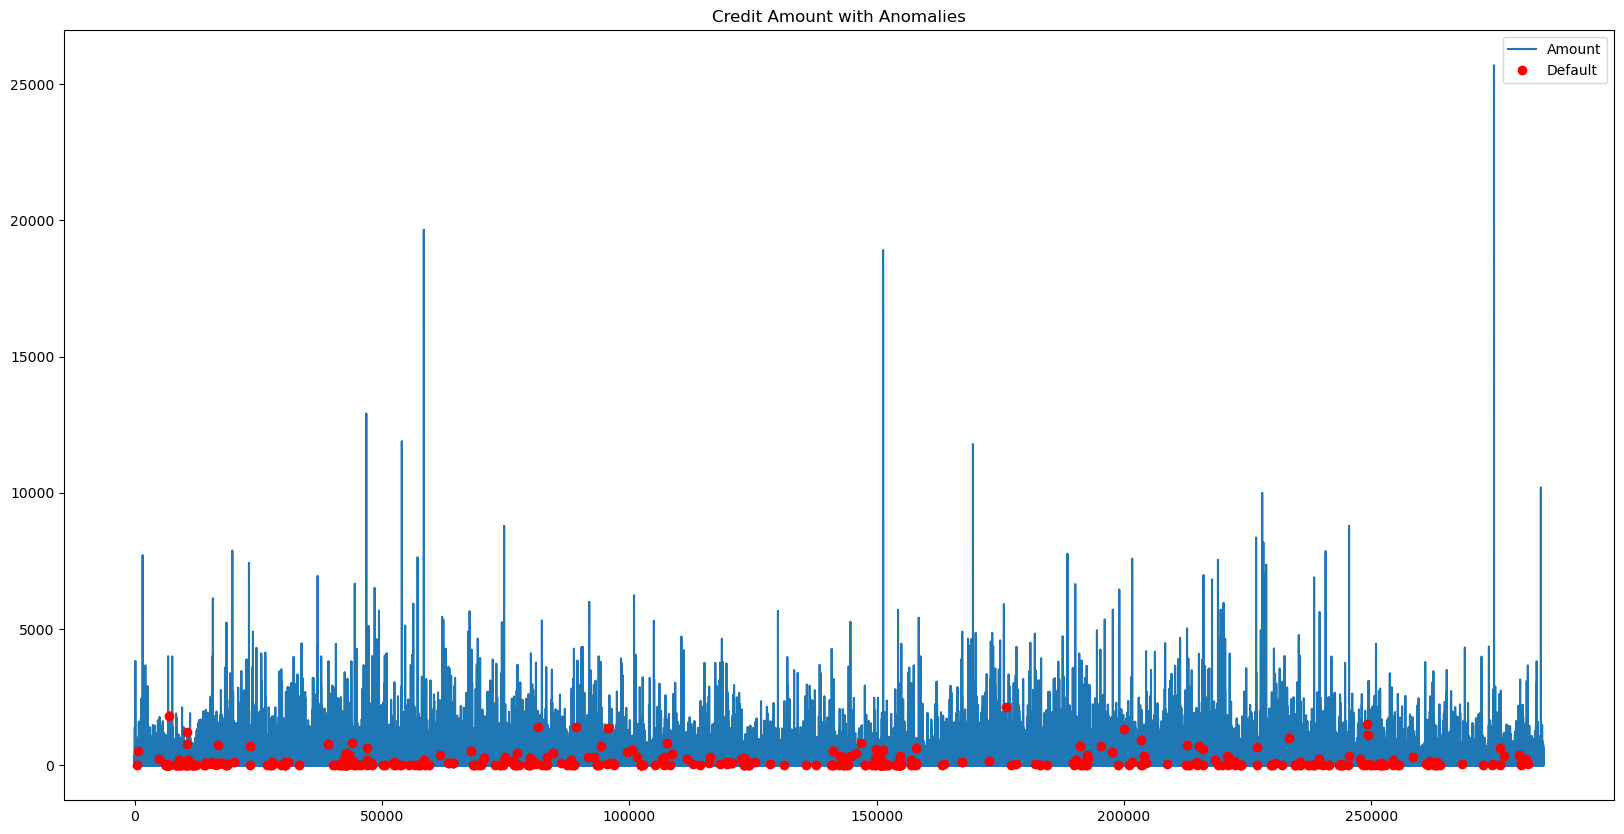

In [10]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value, label='Amount')
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label='Default')
plt.title('Credit Amount with Anomalies')
plt.legend()

# Supervised Setting

In [11]:
dataset = get_transac_n_seconds(df, seconds=1) # Takes 10 sec approx

train_size = int(0.6*len(dataset))

train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]

scaler = StandardScaler()

train = train.copy()
test = test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

### Basic DNN Classifier

In [39]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3

In [40]:
trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = Classifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [41]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 2.574798975887145e-06


epoch loss : 9.880134379937353e-07


In [42]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        preds = torch.sigmoid(preds)
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:01<00:00, 250.51it/s]

ROC-AUC score: 0.945856012471562


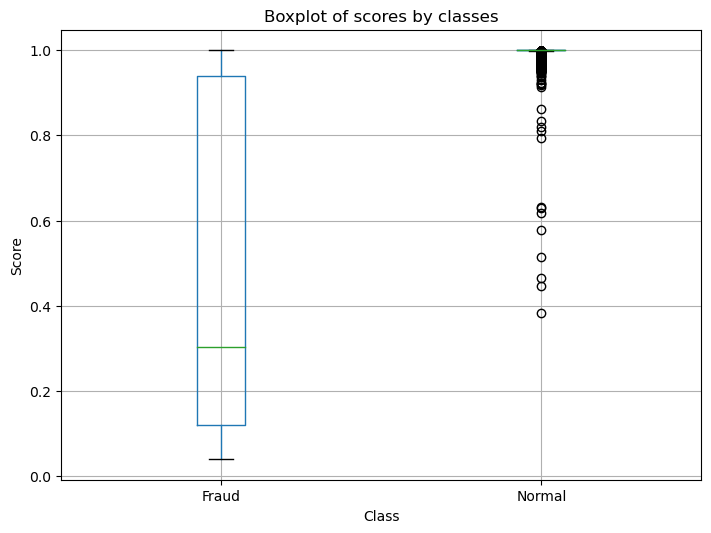

In [ ]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

plt.title("Boxplot of scores by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

# Unsupervised Setting

In [12]:
dataset = df.copy()

train_size = int(0.6 * len(dataset))
train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]
train = train[train['Class'] == 0]

new_train_size = len(train)

dataset = pd.concat([train, test], ignore_index=True)
dataset = get_transac_n_seconds(dataset, seconds=2)

train = dataset.iloc[:new_train_size]
test = dataset.iloc[new_train_size:]

scaler = StandardScaler()

train, test = train.copy(), test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

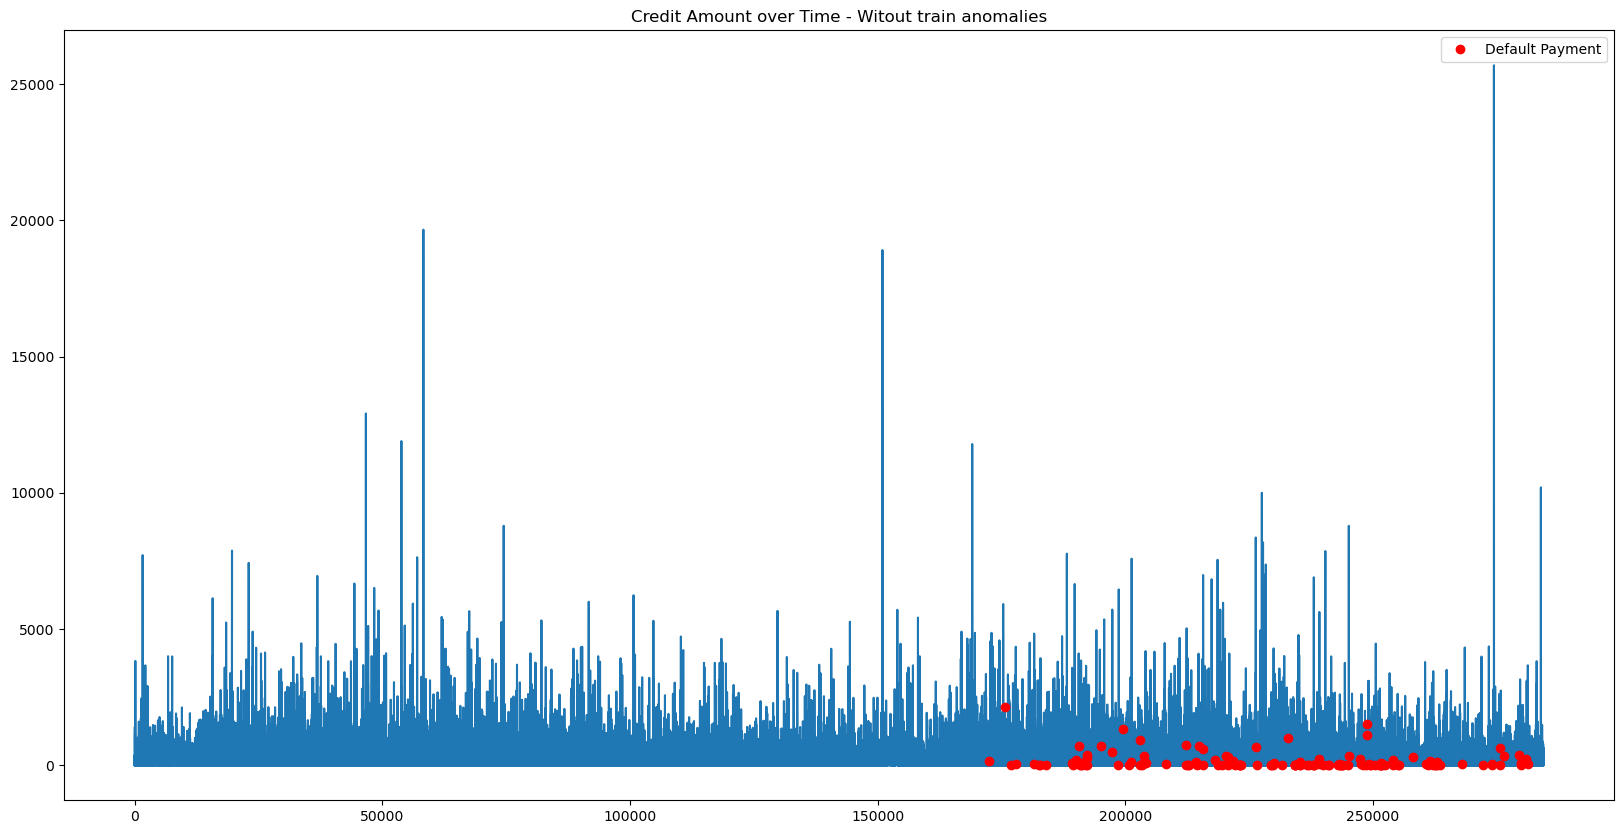

In [13]:
plt.figure(figsize=(20, 10))

value = dataset['Amount']
anomalies = dataset['Class']

indices = range(len(value))
anomalies_indices = [i for i in dataset[dataset['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

### SGD OC-SVM

In [51]:
X_train = train.drop(['Time', 'Class'], axis=1)
X_test = test.drop(['Time', 'Class'], axis=1)
y_test = test['Class']

In [52]:
clf = SGDOneClassSVM().fit(X_train)
prediction = clf.predict(X_test)

prediction = clf.predict(X_test)
prediction = np.where(prediction == -1, 1, 0)

score = roc_auc_score(y_test, prediction)
print(f"ROC-AUC score: {score}")

ROC-AUC score: 0.4894770862477008


### Deep SVDD

In [53]:
LR=1e-3
EPOCHS=10
BATCH_SIZE=256
WEIGHT_DECAY=1e-6
PROJ_DIM=32

In [54]:
model = Projector(proj_dim=PROJ_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=0.1)

In [16]:
svdd = DeepSVDD(model=model, proj_dim=PROJ_DIM, device=DEVICE)
center = svdd.initialize_center(trainloader=trainloader)
results = svdd.train(trainloader=trainloader, epochs=EPOCHS, optimizer=optimizer, scheduler=scheduler)

model = results["model"]
center = results["center"]

Training: 100%|██████████| 667/667 [00:04<00:00, 148.22it/s]


Epoch 1/10 ; Loss: 0.5542


Training: 100%|██████████| 667/667 [00:04<00:00, 134.24it/s]


Epoch 2/10 ; Loss: 0.1673


Training: 100%|██████████| 667/667 [00:04<00:00, 150.74it/s]


Epoch 3/10 ; Loss: 0.0986


Training: 100%|██████████| 667/667 [00:04<00:00, 156.32it/s]


Epoch 4/10 ; Loss: 0.0649


Training: 100%|██████████| 667/667 [00:04<00:00, 139.82it/s]


Epoch 5/10 ; Loss: 0.0445


Training: 100%|██████████| 667/667 [00:04<00:00, 147.85it/s]


Epoch 6/10 ; Loss: 0.0315


Training: 100%|██████████| 667/667 [00:04<00:00, 156.06it/s]


Epoch 7/10 ; Loss: 0.0230


Training: 100%|██████████| 667/667 [00:04<00:00, 152.77it/s]


Epoch 8/10 ; Loss: 0.0172


Training: 100%|██████████| 667/667 [00:04<00:00, 151.45it/s]


Epoch 9/10 ; Loss: 0.0132


Training: 100%|██████████| 667/667 [00:04<00:00, 154.31it/s]

Epoch 10/10 ; Loss: 0.0104


In [17]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        proj = model(test_batch)
        dist = torch.sum((proj - center) ** 2, dim=1)
        all_preds.append(-dist.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:02<00:00, 219.15it/s]


ROC-AUC score: 0.9625425720679299


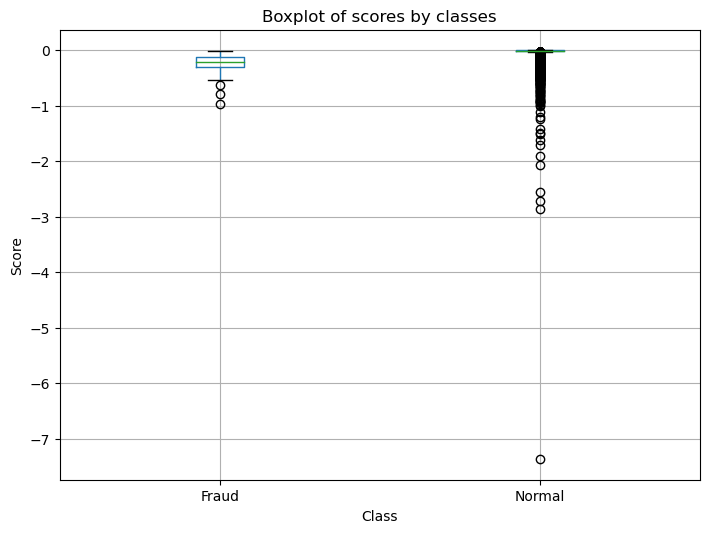

In [18]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### DROCC

In [32]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=5

In [33]:
model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [34]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

model = trainer.get_model()

100%|██████████| 667/667 [00:05<00:00, 125.02it/s]


Epoch: 0, CE Loss: 0.0316091850399971, AdvLoss: 0.0


100%|██████████| 667/667 [01:36<00:00,  6.94it/s]


Epoch: 1, CE Loss: 0.7376508712768555, AdvLoss: 1.0494815111160278


100%|██████████| 667/667 [01:34<00:00,  7.04it/s]


Epoch: 2, CE Loss: 0.6995291709899902, AdvLoss: 0.6304011344909668


100%|██████████| 667/667 [01:30<00:00,  7.38it/s]

Epoch: 3, CE Loss: 0.6862546801567078, AdvLoss: 0.627924919128418


In [35]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:01<00:00, 231.39it/s]

ROC-AUC score: 0.9584483767822081


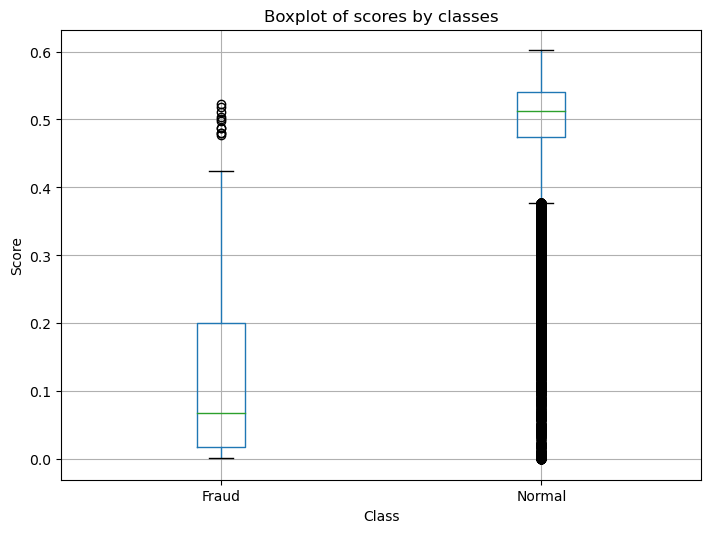

In [36]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### VAE - Reconstruction Loss

In [14]:
LR=1e-4
EPOCHS=10
BATCH_SIZE=256
LATENT_DIM=10

In [7]:
model = VAE(in_dim=30, hidden_dims=[128, 128], latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = LossVAE()

In [63]:
pbar = trange(EPOCHS, desc="Training")
for epoch in pbar:
    epoch_loss = 0

    for inputs, targets in trainloader:
        inputs = inputs.to(DEVICE)
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(inputs, reconstructed, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()

    epoch_loss = epoch_loss/len(trainloader)
    pbar.set_description(f"epoch : {epoch} ; loss : {epoch_loss}")

epoch : 9 ; loss : -194017.61215681222: 100%|██████████| 10/10 [01:56<00:00, 11.64s/it]


In [64]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        reconstructed, mu, logvar = model(test_batch)
        loss = torch.sum((test_batch - reconstructed) ** 2, dim=1)
        all_preds.append(-loss.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:02<00:00, 177.45it/s]

ROC-AUC score: 0.9145518112286135


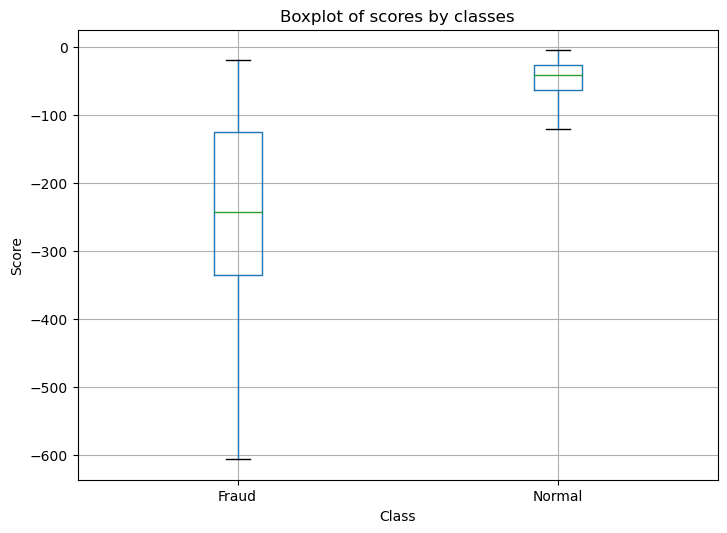

In [66]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()